# [2] Single categorical predictors

# 1. ANOVA

## 1.1 Purpose

- A test that can be used when we have multiple samples of continuous data (3 or more groups)
- Used to find out if the sample came from parent distributions with the same mean
- Generalisation of the two sample Student's t-test

## 1.2 Hypothesis
- Suppose we measure feeding rate of oystercatchers at three sites, characterised by their shelter from wind
<br>
<br>
- H0: The mean feeding rates at all three sites is the same
- H1: The mean feeding rates are not all equal
<br>
<br>
- Use a one-way ANOVA test to check this, because we only have one predictor variable (the categorical variable location)
- Use ANOVA because there are more than 2 groups

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

oystercatcher = pd.read_csv('data/CS2-oystercatcher.csv')
oystercatcher

,feeding,site
0,14.2,Exposed
1,16.5,Exposed
2,9.3,Exposed
3,15.1,Exposed
4,13.4,Exposed
5,18.4,Partial
6,13.0,Partial
7,17.4,Partial
8,20.4,Partial
9,16.5,Partial


In [2]:
oystercatcher_uns = oystercatcher.pivot(columns='site', values='feeding')
oystercatcher_uns

site,Exposed,Partial,Sheltered
0,14.2,NaN,NaN
1,16.5,NaN,NaN
2,9.3,NaN,NaN
3,15.1,NaN,NaN
4,13.4,NaN,NaN
5,NaN,18.4,NaN
6,NaN,13.0,NaN
7,NaN,17.4,NaN
8,NaN,20.4,NaN
9,NaN,16.5,NaN


In [3]:
oystercatcher_uns.describe()

site,Exposed,Partial,Sheltered
count,5.000000,5.000000,5.00000
mean,13.700000,17.140000,23.64000
std,2.715695,2.730934,1.71406
min,9.300000,13.000000,21.50000
25%,13.400000,16.500000,22.20000
50%,14.200000,17.400000,24.10000
75%,15.100000,18.400000,25.10000
max,16.500000,20.400000,25.30000


<AxesSubplot:>

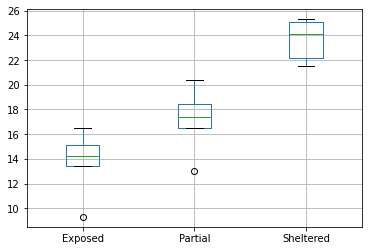

In [4]:
oystercatcher_uns.boxplot()

## 1.3 Implement the test

- Use the ordinary least squares function from the `statsmodels` module to fit a linear model to the data, then use `anova_lm` to carry out the ANOVA analysis

In [7]:
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm

lm = ols('feeding~C(site)', data=oystercatcher).fit() # fits a linear model to data and stores in linear model object
aov_table = anova_lm(lm, typ=1) # Type 1 default, sequential sum of squares ANOVA
aov_table

,df,sum_sq,mean_sq,F,PR(>F)
C(site),2.0,254.812,127.406000,21.507962,0.000108
Residual,12.0,71.084,5.923667,NaN,NaN


## 1.4 Interpretation

- sum_sq and mean_sq used to calculate the F statistic
- df contains degrees of freedom value in each row, 2 and 12
- p-value is 0.000108
<br>
<br>
**A one-way ANOVA showed that the mean feeding rate of oystercatchers differed significantly between locations (F=21.51, df=2,12, p=0.00011)**

## 1.5 Assumptions
1. Parent distributions are normally distributed
2. Each data point is independent
3. Parent distributions have same variance

### 1.5.1 Normality

In [11]:
from scipy.stats import shapiro
exposed = oystercatcher_uns.Exposed.dropna()
partial = oystercatcher_uns.Partial.dropna()
sheltered = oystercatcher_uns.Sheltered.dropna()
print(shapiro(exposed))
print(shapiro(partial))
print(shapiro(sheltered))
# All three p-values are bigger than 0.05, implying normality

ShapiroResult(statistic=0.9151000380516052, pvalue=0.49883610010147095)
ShapiroResult(statistic=0.9691342115402222, pvalue=0.869668185710907)
ShapiroResult(statistic=0.8853233456611633, pvalue=0.3341335952281952)


- Considering each group in turn is considered excessive, and usually it is sufficient to consider the normality of the combined set of residuals from the data

In [12]:
shapiro(lm.resid)

ShapiroResult(statistic=0.9359180331230164, pvalue=0.3338032066822052)

### 1.5.2 Equality of Variance

In [13]:
from scipy.stats import bartlett
bartlett(exposed,partial,sheltered)
# p-value greater than 0.05, implying equal variance

BartlettResult(statistic=0.9063166243374727, pvalue=0.6356174996759745)

### 1.5.3 Graphical Interpretation

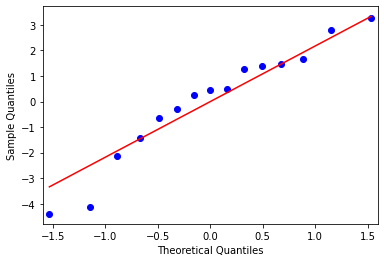

In [15]:
# QQ-plot
from statsmodels.graphics.gofplots import qqplot
q = qqplot(lm.resid,line='s')

Text(0, 0.5, 'Residuals')

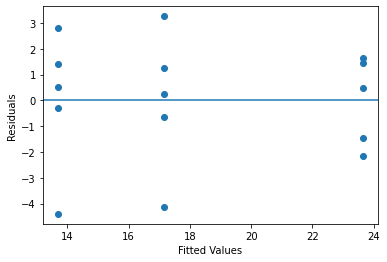

In [16]:
# Residuals vs fitted plot
plt.figure()
plt.scatter(lm.fittedvalues, lm.resid)
plt.axhline(y=0)
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')

- Visulises what the distribution of data within and between each group looks like
- We want all the data to be symmetrically distributed about 0, and for the spread to be the same

Text(0, 0.5, "Cook's Distance")

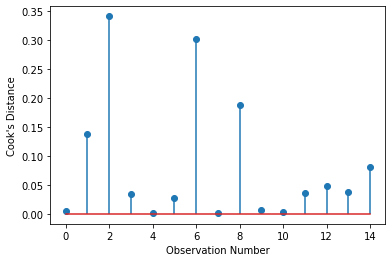

In [18]:
# Cook's Distance plot
plt.figure()
cooks=lm.get_influence().cooks_distance[0]
plt.stem(range(len(cooks)),cooks) # lollipop plot
plt.xlabel('Observation Number')
plt.ylabel("Cook's Distance")

- Way of measuring the influance of each point on the fit of the model
- Graph shows the Cook's distance for each observation
- We don't want any very large Cook's distances
- Values should definitely be below 1, and probably below 0.5
- A large Cook's distance would indicate that a single point is having a large effect on the model
- One could remove that point, run the ANOVA test again and see if conclusions change
<br><br>
- Graphical method should be used for assessing assumptions
- Formal statistical tests can create a false sense of things being absolutely right or wrong

## 1.6 Post-hoc testing

- One drawback of an ANOVA test is that it only tests to see if all the means are the same
- Does not say anything about how pairs of groups differ

<AxesSubplot:>

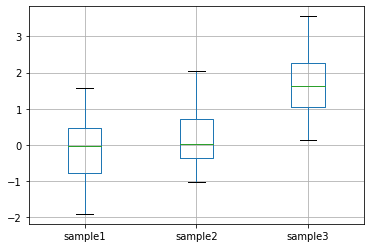

In [19]:
tukey = pd.read_csv('data/CS2-tukey.csv')
tukey_uns = tukey.pivot(columns='group',values='response')
tukey_uns.boxplot()

In [21]:
# Test for a significant difference in group means
lm = ols('response~C(group)',data=tukey).fit()
aov_table = anova_lm(lm,typ=1)
aov_table

,df,sum_sq,mean_sq,F,PR(>F)
C(group),2.0,33.850044,16.925022,20.159922,2.391626e-07
Residual,57.0,47.853670,0.839538,NaN,NaN


- Test has rejected the hypothesis that all means are equal
- However this was not due to all the sample means being different, but rather just because one of the groups is very different from the others
<br> <br>
- Use a new test called Tukey's range test, which will compare all groups in a pairwise fashion

In [22]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd, MultiComparison
mc = MultiComparison(tukey.response, tukey.group)
mc_results = mc.tukeyhsd()
print(mc_results)

Multiple Comparison of Means - Tukey HSD, FWER=0.05 
 group1  group2 meandiff p-adj   lower  upper  reject
-----------------------------------------------------
sample1 sample2   0.3038 0.5474 -0.3935  1.001  False
sample1 sample3   1.7234  0.001  1.0261 2.4206   True
sample2 sample3   1.4196  0.001  0.7224 2.1168   True
-----------------------------------------------------


- There isn't a significant difference between sample1 and sample2
- But there is a significant difference between sample1/sample3 and sample2/sample3

- Some controversy about using lots of tests - "p-hacking"
- Tukey's range test requires the same three assumptions as an ANOVA